# Описание проекта

Допустим, добывающей компании «King Oil» нужно выбрать оптимальный регион для бурения новых скважин.

Мы располагаем пробами нефти в трёх регионах: в каждом 10 000 месторождений, где нам известны качество нефти и объём запасов. Необходимо построить модель машинного обучения, которая будет способна помочь определить регоин, где бурение и последующая добыча принесёт наибольшую прибыль. Также важно проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах:

 - /datasets/geo_data_0.csv
 - /datasets/geo_data_1.csv
 - /datasets/geo_data_2.csv
 
 
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
 - product — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**

Для обучения используем только линейную регрессию.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Содержание проекта**
- [1. Загрузка и подготовка данных](#1.-Загрузка-и-подготовка-данных)
- [2. Обучение и проверка модели](#2.-Обучение-и-проверка-модели)
- [3. Подготовка к расчёту прибыли](#3.-Подготовка-к-расчёту-прибыли)
- [4. Расчёт прибыли и рисков](#4.-Расчёт-прибыли-и-рисков) 
- [Вывод](#Вывод)

# 1. Загрузка и подготовка данных

Для начала импортируем все необходимые нам библиотеки и инструменты.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

Данные загрузим в переменные data_0, data_1, data_2.

In [2]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

Поскольку датасеты имеют одинаковую структуру, напишем функцию для описания данных, где просмотрим первые строки, получим информацию о структуре, описательную статистику и сведения о дубликатах.

In [3]:
# функция принимает на вход датафрейм, к которому по очереди применяются методы

def data_description(data):
    display(data.head())
    
    display(data.info())
    
    display(data.describe(include='all').T)
    
    display('Дубликаты', data[data.duplicated()])
    print('-'*100)

Опишем данные, переберем датафреймы в цикле.

In [4]:
for df in [region_1, region_2, region_3]:
    data_description(df)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,Tdehs,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331
f1,100000.0,NaN,NaN,NaN,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,NaN,NaN,NaN,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379
product,100000.0,NaN,NaN,NaN,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


'Дубликаты'

,id,f0,f1,f2,product


----------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,5ltQ6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,NaN,NaN,NaN,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,NaN,NaN,NaN,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,NaN,NaN,NaN,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


'Дубликаты'

,id,f0,f1,f2,product


----------------------------------------------------------------------------------------------------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,Vcm5J,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,NaN,NaN,NaN,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801
f2,100000.0,NaN,NaN,NaN,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,NaN,NaN,NaN,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


'Дубликаты'

,id,f0,f1,f2,product


----------------------------------------------------------------------------------------------------


Мы видим, что пропусков  и явных дубликатов в данных нет.

Однако встречаются одинаковые значения id, но под ними скрываются скважины с разными характеристиками.

Вероятно, это следствие синтетической природы данных, просто так случайно получилось, что id одинаковые.

Также, сравнивая описательную статистику, видно, что первый и третий датасет похожи - средний запас в скважине и стандартное отклонение находятся приблизительно на одном уровне.

Далее попробуем визуализировать распределения признаков и целевого признака по всем трем датасетам, чтобы попробовать понять, как они отличаются между собой. Сведем все графики в один рисунок.

Для этого напишем функцию.

In [5]:
# функция принимает на вход три датафрейма, создается форма с 12 графиками
# ряд большого графика отражает распределение призаков и целевого признака по отдельному датафрейму

def histograms_all(df_0,df_1,df_2):
    
    fig, axes = plt.subplots(3,4,figsize=(16,10))   
    
    columns_to_plot = df_0.columns[1:5]
    
    for i in range(len(columns_to_plot)):
        sns.distplot(df_0[columns_to_plot[i]], ax=axes[0, i], color='r')  
        
    for i in range(len(columns_to_plot)):
        sns.distplot(df_1[columns_to_plot[i]], ax=axes[1, i], color='g')
        
    for i in range(len(columns_to_plot)):
        sns.distplot(df_2[columns_to_plot[i]], ax=axes[2, i], color='b')

Вызовем функцию для наших наборов данных.

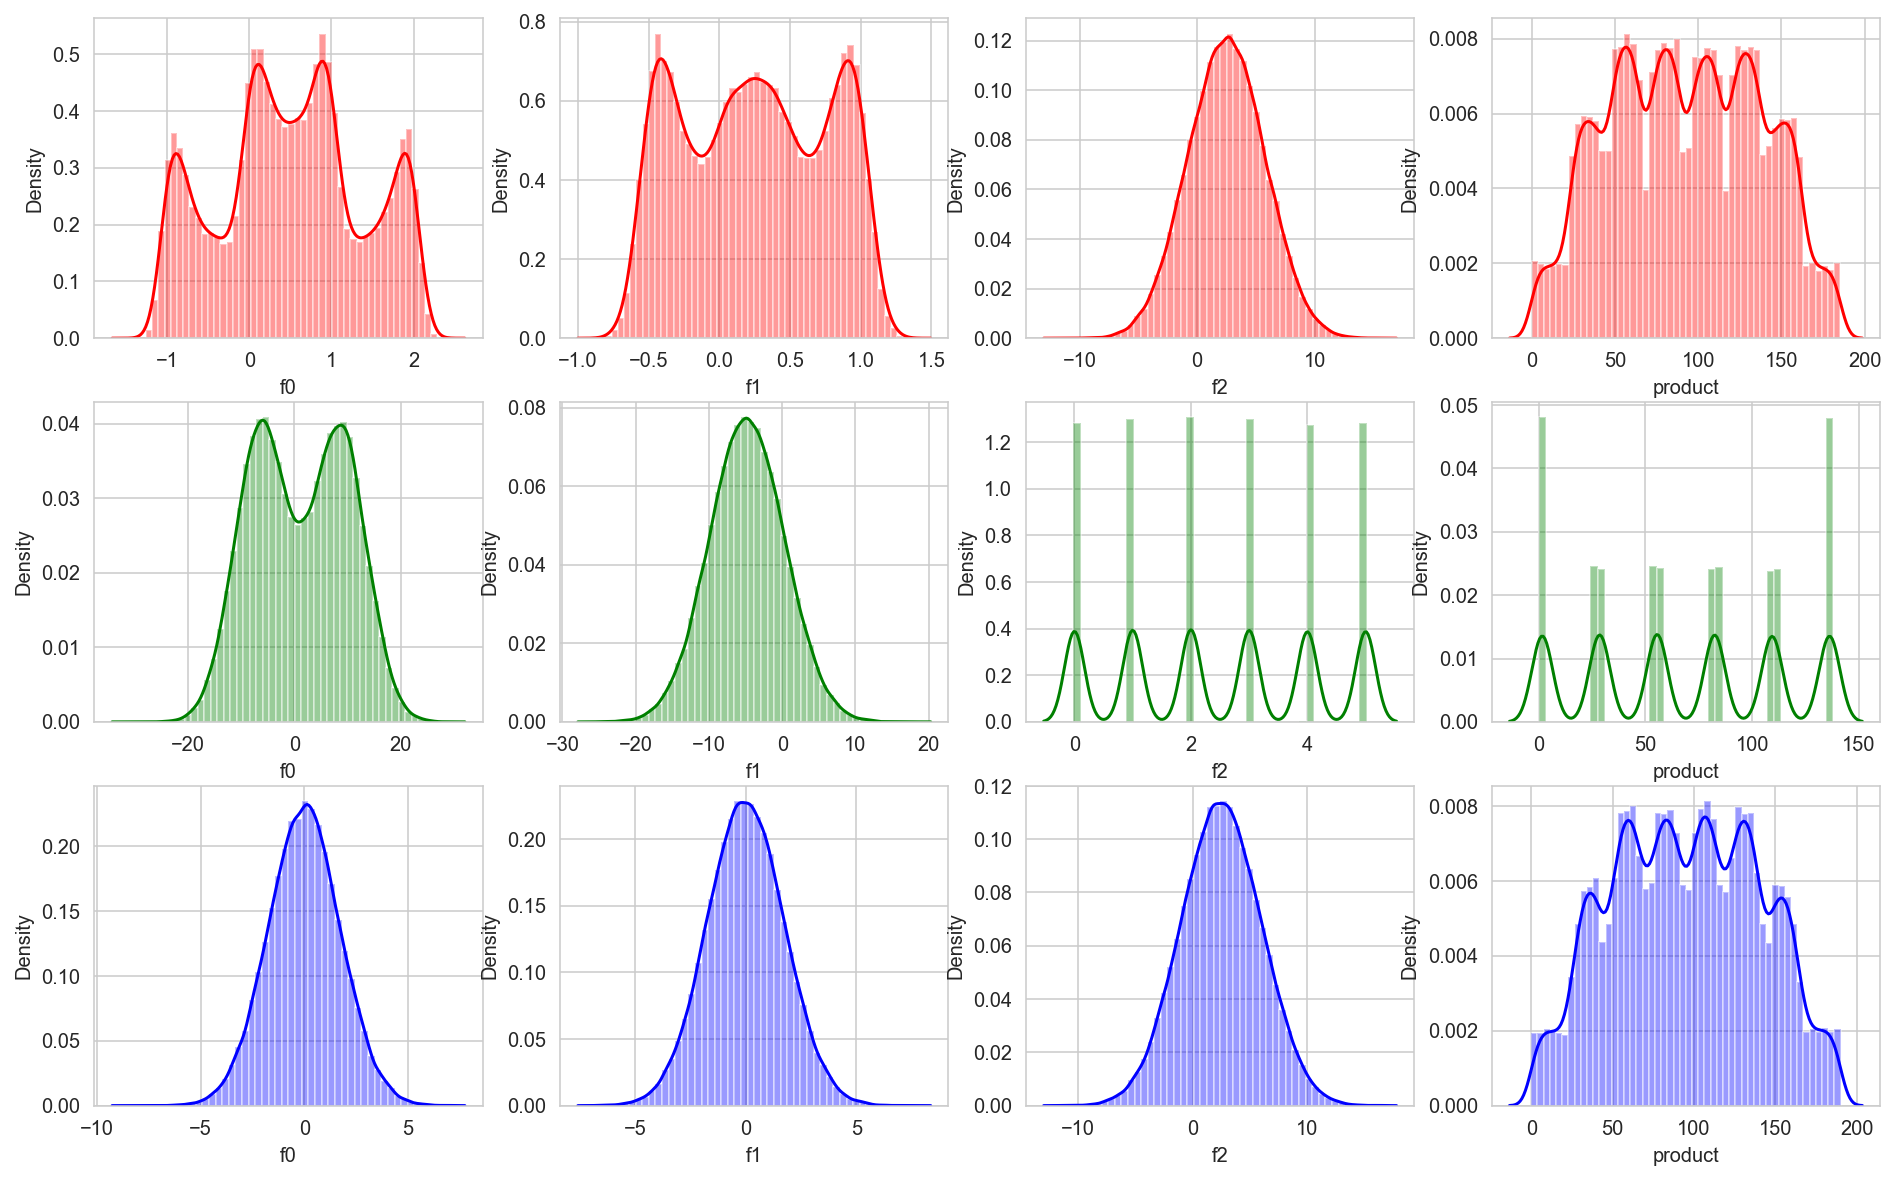

In [6]:
sns.set_style('whitegrid')
histograms_all(region_1, region_2, region_3)

Получилась крайне любопытная картина. Распределение запасов в скважине первого и третьего региона и правда достаточно похоже, при том, что у первого региона только признак f2 распределен нормально, а у третьего - все три.

Наиболее занимательным выглядит второй датасет. Видно, что признак f2 и целевой признак принимают только отдельные значения. Вероятно, они обладают очень сильной корреляцией. Трудно сказать, насколько такое явление может иметь место при разработке реальных скважин, но поскольку данные синтетические, то примем это как данность.

Для того, чтобы оценить корреляцию признаков и запасов в скважине - измерим ее и построим тепловые карты. Для этого напишем функцию.

In [7]:
# фнукция принимает в качестве аргумента датафрейм, отбрасываем столбец 'id'
# считаем корреляцию и применяем к ней тепловую карту, повторяющиеся связи - скрываем

def heat_map(df,df_name):
    df = df.drop('id', axis=1)
    corr = df.corr(method='pearson')
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', linewidths=0.5)
    plt.title(df_name)

Вызовем функцию в цикле. 

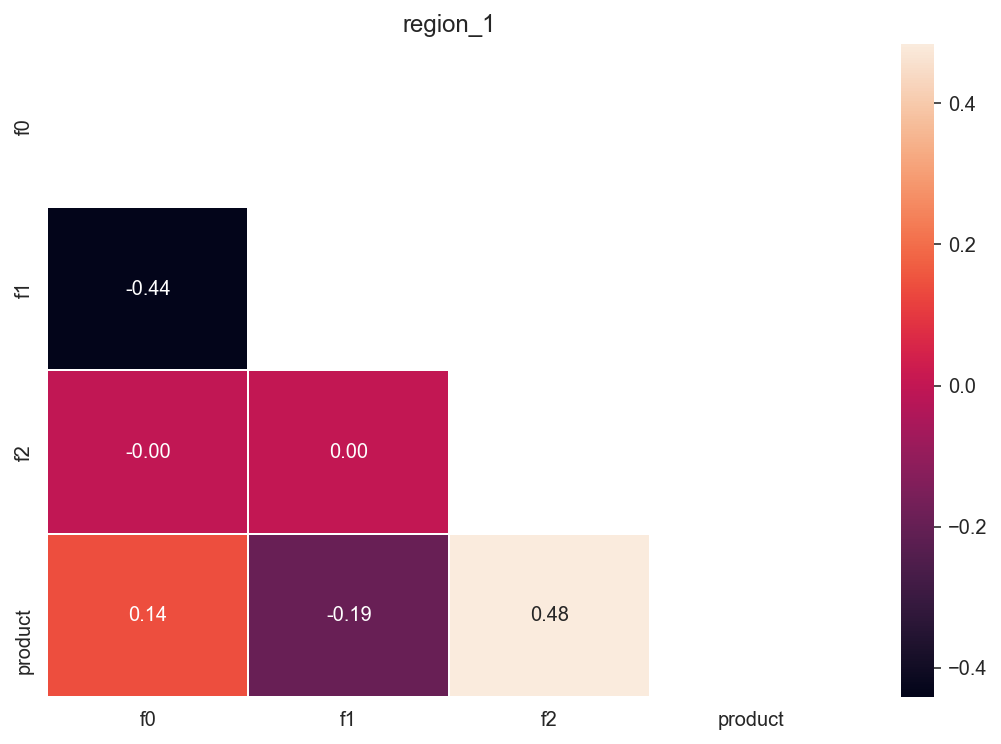

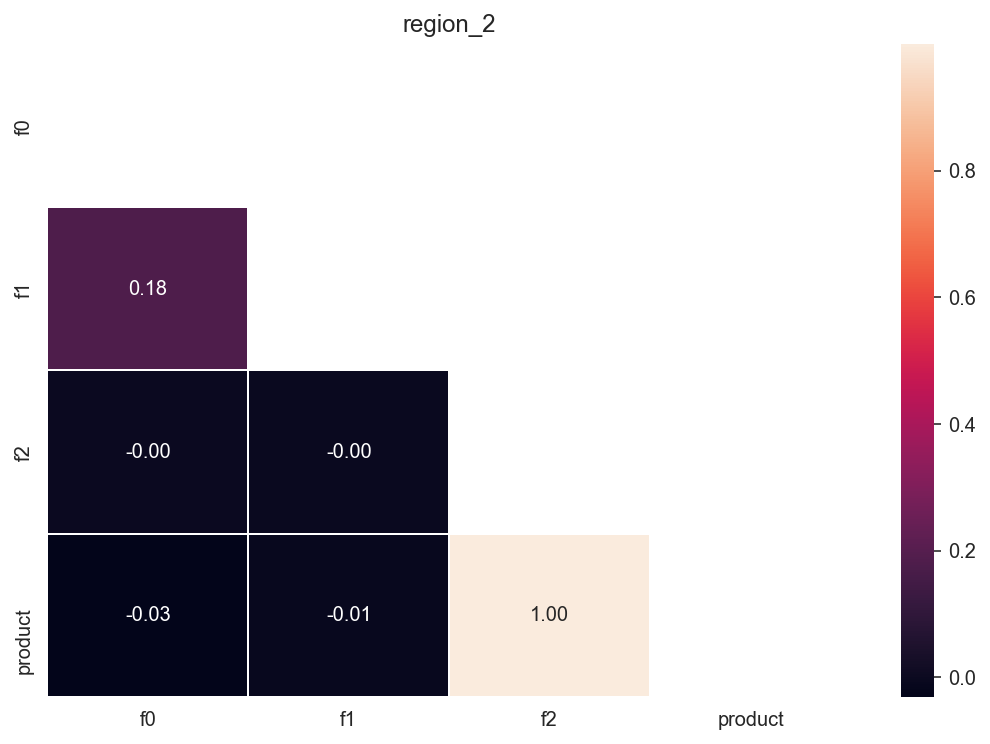

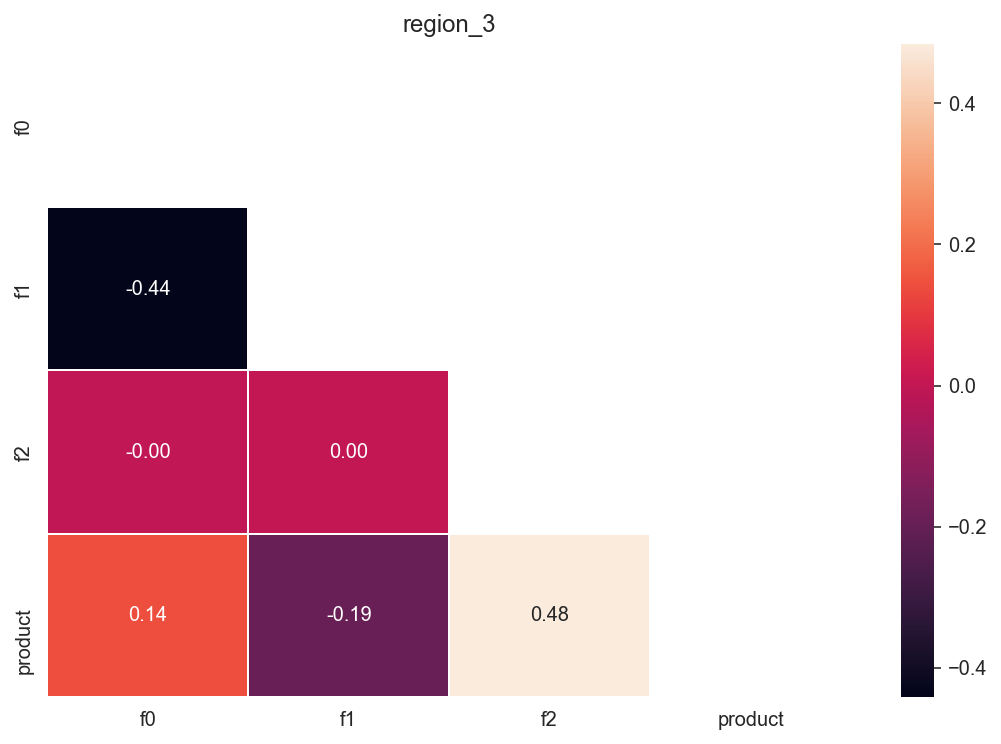

In [8]:
for k,df in {'region_1': region_1, 'region_2': region_2, 'region_3': region_1}.items():
    heat_map(df, k)

Получаем, что признаки f0 и f1 не имеют связи с целевым признаком по всем датасетам.

Есть связь запасов только с признаком f2, для первого и третьего набора данных коэффициент корреляции около 0.5, для второго, как и предполагалось выше - единица.

По всей видимости, такая связь f2 и запасов позволит нам построить очень точную модель линейной регрессии для второго региона.

# 2. Обучение и проверка модели

Итак, приступим к обучению и проверке моделей.

Для разбивки данных на обучающую и валидационную выборки напишем функцию, в которой будем вызывать train_test_split.

In [9]:
# функция получает в качестве аргумента датафрейм, определяем целевой столбец, отбрасываем его и 'id'
# создаем переменные для признаков и целей обучающей и валидационной выборок
# и присваиваем в них результат вызова train_test_split

def split_for_train_valid(df):
    target = df['product']
    features = df.drop(['id','product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                test_size=0.25, random_state=1)
    return features_train, features_valid, target_train, target_valid

После того, как мы обучим модели и сделаем предсказания, нам потребуется сохранить предсказания и ответы на валидационной выборке, а также вывести на экран средний предсказанный объем запасов и корень из средней квадратичной ошибки.

Для этих целей также напишем функцию, внутри которой будет проходить обучение модели, предсказание и расчет необходимых метрик.

Дополнительно рассчитаем R2.

In [10]:
# функция в аргументе будет получать массивы, которые возвращает функция split_for_train_valid

def predicted_mean_and_rmse(arrays):
    model = LinearRegression()
    model = model.fit(arrays[0], arrays[2]) # индексы соответствуют порядку в split_for_train_valid
    predictions_valid = model.predict(arrays[1])
    
    rmse = mean_squared_error(arrays[3], predictions_valid) ** 0.5
    mean_prediction = predictions_valid.mean()
    R2 = model.score(arrays[1], arrays[3])
    
    return predictions_valid, arrays[3], mean_prediction, rmse, R2, model

Затем создадим нужные нам переменные для каждого региона, в которые присвоим результат вызова predicted_mean_and_rmse.

В predicted_mean_and_rmse, в виде аргумента будет передаваться функция split_for_train_valid, в которую, в свою очередь, в виде аргумента будет передаваться нужный нам датафрейм.

In [11]:
predictions_valid_1, target_valid_1, mean_product_1, rmse_1, R2_1, model_1 = \
                                            predicted_mean_and_rmse(split_for_train_valid(region_1))

predictions_valid_2, target_valid_2, mean_product_2, rmse_2, R2_2, model_2 = \
                                            predicted_mean_and_rmse(split_for_train_valid(region_2))

predictions_valid_3, target_valid_3, mean_product_3, rmse_3, R2_3, model_3 = \
                                            predicted_mean_and_rmse(split_for_train_valid(region_3))

Далее выведем на экран интересующие нас результаты.
Создадим словарь для удобства.

In [12]:
regions = {'Первый регион' : [mean_product_1, rmse_1, R2_1],
           'Второй регион' : [mean_product_2, rmse_2, R2_2],
           'Третий регион' : [mean_product_3, rmse_3, R2_3]}

In [13]:
for region, values in regions.items():
    print(region)
    print(f'Средний запас предсказанного сырья: {values[0]:.2f} тыс. баррелей')
    print(f'RMSE: {values[1]:.2f} тыс. баррелей')
    print(f'R2: {values[2]:.2f}')
    print('')

Первый регион
Средний запас предсказанного сырья: 92.49 тыс. баррелей
RMSE: 37.74 тыс. баррелей
R2: 0.28

Второй регион
Средний запас предсказанного сырья: 69.12 тыс. баррелей
RMSE: 0.89 тыс. баррелей
R2: 1.00

Третий регион
Средний запас предсказанного сырья: 94.96 тыс. баррелей
RMSE: 39.87 тыс. баррелей
R2: 0.20



Итак, мы видим, что средний предсказанный запас сырья в скважине в первом и третьем регионе находится примерно на одном уровне. В то время как во втором регионе он более чем на 20 тыс. баррелей ниже.

У предсказаний по первому и третьему региону велик корень из средней квадратичной ошибки - почти 40 тыс. баррелей.

Второй регион, данные по которому обладали признаком, имеющим очень сильную связь с запасами в скважине, показал незначительный RMSE.

Как следствие, коэффициенты детерминации для моделей первого и третьего регионов говорят о том, что дисперсия запасов в скважине только на 28% и 20% соответственно объясняется признаками f0, f1, f2.

Это означает, что модели для первого и третьего регионов обладают достаточно низким качеством, в то время как модель для второго региона предсказывает запасы почти идеально.

# 3. Подготовка к расчёту прибыли

На этом этапе подготовимся к расчету прибыли.

Сразу оговоримся, что все будем считать в рублях и баррелях, а не в тыс. рублей и тыс. баррелей, если не будет отмечено отдельно.

Итак, бюджет для разработки скважин составляет 10 млрд руб.

Доход (или выручка) от одного барреля сырья составляет 450 рублей.

Нам нужно разработать 200 скважин, отдельно запишем это значение в переменную.

In [14]:
total_budget = 10000000000
revenue_per_barrel = 450
wells_for_drilling = 200

Далее посчитаем, сколько нужно потратить на бурение одной скважины.

При расчете мы исходим из предположения о том, что скважины все относительно стандартные и бюджет для бурения каждой - одинаков. В любом случае, условий задачи недостаточно, чтобы сделать другие выводы.

In [15]:
investments_per_well = total_budget / wells_for_drilling
print(f'{investments_per_well:.0f}')

50000000


Получается, что 50 млн руб. - бюджет для разработки одной скважины.

Посчитаем, сколько сырья должно быть в скважине, чтобы ее разработка была безубыточной.

Разделим бюджет для скважины на выручку с барреля.

In [16]:
breakeven_reserves_per_well = investments_per_well / revenue_per_barrel
print(f'{breakeven_reserves_per_well:.0f}')

111111


Следовательно, 111 тыс. баррелей должно быть в одной скважине, чтобы не было убытков.

Это число превышает средний запас сырья в скважине на величину около 20 тыс. баррелей для первого и третьего регионов, и почти в 2 раза - для второго.

Посмотрим, сколько всего скважин в каждом регионе превышает безубыточный уровень.

In [17]:
for predictions in [predictions_valid_1, predictions_valid_2, predictions_valid_3]:
    print(len(predictions[predictions > breakeven_reserves_per_well / 1000]))

5393
4634
5375


В каждом регионе только около 20% скважин, согласно предсказаниям моделей, превышают безубыточный уровень.

# 4. Расчёт прибыли и рисков

Итак, приступим к созданию функции расчета прибыли.

Функция для расчета прибыли должна выбирать скважины с наибольшей величиной предсказанных запасов, и на основе ответов посчитать выручку.

In [18]:
# функция принимает в аргументах ответы, предсказания и количество скважин для разработки
# мы сортируем массив с предсказаниями по убыванию и выбираем нужное число скважин из массива ответов
# затем умножаем сумму запасов на выручку с барреля и вычитаем общий бюджет

def profit(wells_target, wells_predicted, number_of_wells_to_pick):
    
    wells_predicted_sorted = pd.Series(wells_predicted).sort_values(ascending=False)
    wells_picked = wells_target[wells_predicted_sorted.index][:number_of_wells_to_pick]
    wells_picked_total_product = wells_picked.sum() * 1000
    
    profit = wells_picked_total_product * revenue_per_barrel - total_budget
    return profit

Создав функцию для расчета прибыли, создадим функцию и для операции бутстреп, чтобы потом применять ее для регионов.

Внутри нее рассчитаем также 95% доверительный интервал, а также риск убытков.

Риск убытков рассчитаем функцией модуля scipy.stats.percentileofscore, которая покажает, какой процент значений массива с прибылями лежит ниже нуля. Это для нас и будет выражение риска убытков.

Также внутри функции перезагрузим индексы для ответов, поскольку они принадлежат интервалу от 0 до 100000 случайным образом, а индексы предсказаний идут по порядку от 0 до 24999.

In [19]:
# функция принимает ответы, предсказания, кол-во скважин для рассмотрения и для разработки
# формируем подвыборку ответов случайным образом, затем отбираем предсказания по индексу ответов
# для прибыли вызывается функция profit с аргументами "подвыборка ответов", "подвыборка предсказаний"
# и "кол-во скважин для разработки"
# возвращает массив с прибылями, среднюю прибыль, границы 95% доверительного интервала и риск убытков

def profit_bootstrap(target, predictions, number_of_wells_to_observe, number_of_wells_to_pick):
    
    state = np.random.RandomState(17)
    profits = []
    predictions = pd.Series(predictions)
    
    target_new_index = target.reset_index(drop=True)
    
    for i in range(1000):
        target_subsample = target_new_index.sample(n=number_of_wells_to_observe, replace=True, 
                                               random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        profits.append(profit(target_subsample, predictions_subsample, number_of_wells_to_pick))
        
    profits = pd.Series(profits)
    mean_profit = profits.mean()
    
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    
    loss_risk = st.percentileofscore(profits, 0)  #какой процент значений ниже нуля
    
    return profits, mean_profit, lower, upper, loss_risk

Итак, создав функцию, присвоим результаты ее вызова в интересующие нас переменные.

In [20]:
profits_1, mean_profit_1, lower_1, upper_1, loss_risk_1 = profit_bootstrap(target_valid_1,
                                                                    predictions_valid_1,500, 200)

profits_2, mean_profit_2, lower_2, upper_2, loss_risk_2 = profit_bootstrap(target_valid_2,
                                                                    predictions_valid_2, 500, 200)

profits_3, mean_profit_3, lower_3, upper_3, loss_risk_3 = profit_bootstrap(target_valid_3,
                                                                    predictions_valid_3, 500, 200)

Создадим словарь для перебора параметров.

In [21]:
profit_metrics = {'Первый регион' : [mean_profit_1, lower_1, upper_1, loss_risk_1],
           'Второй регион' : [mean_profit_2, lower_2, upper_2, loss_risk_2],
           'Третий регион' : [mean_profit_3, lower_3, upper_3, loss_risk_3]}

In [22]:
for region, values in profit_metrics.items():
    print(region)
    print(f'Средняя прибыль: {values[0] / 1000000:.0f} млн руб.')
    print(f'95% доверительный интервал для прибыли:({values[1] / 1000000:.0f},{values[2] / 1000000:.0f}) млн руб.')
    print(f'Риск убытков: {values[3]}%')
    print('')

Первый регион
Средняя прибыль: 462 млн руб.
95% доверительный интервал для прибыли:(-137,991) млн руб.
Риск убытков: 6.1%

Второй регион
Средняя прибыль: 530 млн руб.
95% доверительный интервал для прибыли:(83,962) млн руб.
Риск убытков: 1.0%

Третий регион
Средняя прибыль: 412 млн руб.
95% доверительный интервал для прибыли:(-118,976) млн руб.
Риск убытков: 6.6%



# Вывод

Итак, риск убытков выше 2.5% в в первом и третьем регионе. Значит, по этому параметру отбора региона для разработки дальше они не проходят.

Остается второй регион, где риск убытков составляет 1%, да и значение средней прибыли выше, чем в остальных.

Наверное, этот регион отобран "по праву", поскольку модель предсказания запасов для его скважин выглядит самой качественной, оценивая параметр R2. Опять-таки, принимая как данность тот факт, что для этого региона значения параметра f2 и запасов обладают ярко выраженной синтетичностью.